Note: This is copied from my [model-implementations](https://github.com/aryaman1802/model-implementations/tree/main/generative-deep-learning) Github repository. For any updates, please check there.

## **Denoising Diffusion Probabilistic Models (DDPM)**

Papers:
- [Denoising Diffusion Probabilistic Models (DDPMs)](https://arxiv.org/abs/2006.11239)
- [Improved Denoising Diffusion Probabilistic Models](https://arxiv.org/abs/2102.09672)

Helpful resources:
- [Hugging Face Annotated Diffusion model](https://huggingface.co/blog/annotated-diffusion)
- [ExplainingAI's Diffusion model playlist](https://youtube.com/playlist?list=PL8VDJoEXIjpo2S7X-1YKZnbHyLGyESDCe&si=AaaLdEAOgHEGuSes)
- [AI Summer's blog on Diffusion model](https://theaisummer.com/diffusion-models/)
- [Lilian Weng's blog on Diffusion model](https://lilianweng.github.io/posts/2021-07-11-diffusion-models/)
- [Calvin Luo's blog on Diffusion model](https://calvinyluo.com/2022/08/26/diffusion-tutorial.html)
- [AssemblyAI's blog on Diffusion model](https://www.assemblyai.com/blog/diffusion-models-for-machine-learning-introduction/)
- [DeepFindr's video on Diffusion model](https://youtu.be/a4Yfz2FxXiY?si=b0vNH-azD7rRQ7Mj)
- Outlier's videos on Diffusion model:
    - [Basic version](https://youtu.be/HoKDTa5jHvg?si=qBtBSLaQ84jXrgqe)
    - [Score-Based version](https://youtu.be/B4oHJpEJBAA?si=ocOaT4XvuAqusJZe)
- [Ari Seff's video on Diffusion model](https://youtu.be/fbLgFrlTnGU?si=cJvyNouDr-pMDUi_)
- [Demystifying Diffusion Models](https://goyalpramod.github.io/blogs/demysitifying_diffusion_models/)

This notebook just includes the implementation of the DDPM model and its training loop. The results are not shown here.

Feel free to check the results on my Kaggle notebook: https://www.kaggle.com/code/aryamanbansal/basic-diffusion-model

## **Basic Diffusion Model**

This notebook tries to explain the basic version of the diffusion model.

In [2]:
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torch import einsum
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms, models
from torchinfo import summary
from torch import GradScaler, autocast

from einops import rearrange, reduce
from einops.layers.torch import Rearrange

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random

import os
from functools import partial
from tqdm import tqdm
from datetime import datetime
import pytz
import copy
import time
import gc

print("imports done!")

imports done!


In [14]:
# Imports

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms, models
from torchinfo import summary
from torch import GradScaler, autocast

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random

import os
from tqdm import tqdm
from datetime import datetime
import pytz
import copy
import gc

print("imports done!")

imports done!


In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
     transforms.Resize((224, 224))
    ])

batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='./', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)

testset = torchvision.datasets.CIFAR10(root='./', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100%|██████████| 170M/170M [00:10<00:00, 16.1MB/s] 


Extracting ./cifar-10-python.tar.gz to ./
Files already downloaded and verified


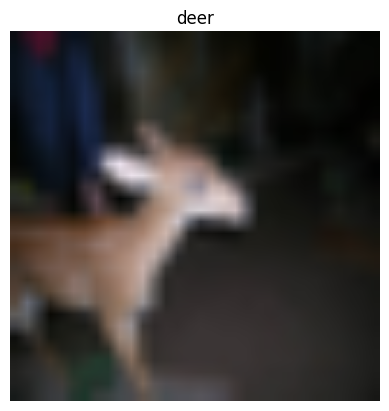

In [15]:
def fn():
    dataiter = iter(trainloader)
    images, labels = next(dataiter)
    img = images[0]
    img = img/2 + 0.5   # unnormalize (makes the image better looking)
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)))
    plt.title(classes[labels[0]])
    plt.axis("off")
    

fn()

In [16]:
def get_single_img():
    """
    Returns a single image as a numpy array.
    """
    dataiter = iter(trainloader)
    images, labels = next(dataiter)
    img = images[0]
    img = img/2 + 0.5   # unnormalize (makes the image better looking)
    return img

get_single_img().shape

torch.Size([3, 224, 224])

## **Introduction & Big Picture**

Diffusion models are a class of deep generative models that create data (such as images, audio, or text) by progressively "denoising" a sample starting from pure noise. The key idea is to learn a transformation that can reverse a gradual, stochastic (random) corruption process applied to the data. In other words, instead of directly learning a mapping from noise to data, the model learns to undo small, incremental steps of noise addition.

The entire mechanism of diffusion models can be thought of as a two-step process:
1. **Forward Diffusion Process**: The data is incrementally noised until it becomes nearly indistinguishable from pure random noise.
    - The process starts with a clean data sample and then gradually adds (Gaussian) noise over a series of steps. This controlled degradation is often modeled using a Markov chain, where each step adds a little bit of noise.
    - This process is defined by a noise schedule, which determines how much noise is added at each step.
2. **Reverse (Denoising) Process**: Starting from this noise, the model then carefully "rewinds" the noising process, step-by-step reconstructing the original data.
    - The model is trained to reverse the forward process. Starting from a sample of pure noise, it predicts and subtracts the noise step-by-step until it recovers a clean data sample.
    - The reverse process often relies on learning the conditional probabilities that estimate how to remove noise at each step.

## **Before we begin...**

The Diffusion model is a complicated model (we'll un-complicate it soon enough :)). It's a good idea to have a basic understanding of the following concepts before diving into the model (feel free to skip them if you already know about them):

#### 1. **Multivariate normal distribution**

Normal distribution, but in multiple dimensions.

- Covariance matrix = Variance-covariance matrix
- Symmetric matrix that describes the covariance between two or more random variables.
- In such matrices, you find variances (on the main diagonal) and covariances (on the off-diagonal).

#### 2. **Gaussian noise**

Gaussian distribution = Normal distribution 

#### 3. **Markov chain**

Quoting from [Wikipedia](https://en.wikipedia.org/wiki/Markov_chain#:~:text=In%20probability%20theory%20and%20statistics,attained%20in%20the%20previous%20event.), "A Markov chain or Markov process is a [stochastic process](https://en.wikipedia.org/wiki/Stochastic_process) describing a sequence of possible events in which the probability of each event depends only on the state attained in the previous event".

<figure>
  <div style="text-align: center;">
  <img src="https://upload.wikimedia.org/wikipedia/commons/thumb/2/2b/Markovkate_01.svg/390px-Markovkate_01.svg.png" alt="two-state markov chain"/>
  </div>
  <figcaption>
  <p style="text-align:center;">
  <b>A diagram representing a two-state Markov process. The numbers are the probability of changing from one state to another state.</b>
  </p>
  <p style="text-align:center;">
  Source: <a href="https://en.wikipedia.org/wiki/Markov_chain#:~:text=In%20probability%20theory%20and%20statistics,attained%20in%20the%20previous%20event.">Wikipedia</a>
  </p>
  </figcaption>
</figure>

For more details, check [this](https://builtin.com/machine-learning/markov-chain) article.

## **Forward Diffusion Process**

<figure>
  <div style="text-align: center;">
  <img src="https://theaisummer.com/static/9bb372bb74034360fe7891d546e3c5b4/01dae/reverse-diffusion.png" alt="forward diffusion process"/>
  </div>
  <figcaption>
  <p style="text-align:center;">
  <b>Forward Diffusion process.</b>
  </p>
  <p style="text-align:center;">
  Source: <a href="https://theaisummer.com/diffusion-models/">AI Summer</a> (original by <a href="https://arxiv.org/abs/2006.11239">Ho et al. 2020</a>)
  </p>
  </figcaption>
</figure>

- The forward diffusion process is a Markov chain of $T$ steps ($x_0$ doesn't count as it is the original image without any noise).
    - Each circled element that we see in the above image is an element of a Markov chain.
    - In a Markov chain, each element only depends on the immediate preceding element. For example, the above circled elements are all part of a Markov chain, and each element only depends on the element before it, ie, $x_{t+1}$ depends on $x_t$ only, and not on $x_{t-1}$, $x_{t-2}$, etc. 
    - Thus, the forward diffusion process is a sequence of $T$ steps ($x_0, \ldots, x_T$), where each subsequent is noiser than its predecessor, ie, $x_{t+1}$ is noiser than $x_t$. 
    $$\underbrace{x_0}_{\text{clean data}} \rightarrow \;\; \ldots \;\; \rightarrow \underbrace{x_T}_{\text{pure (Gaussian) noise}}$$

&nbsp;  

- The process of gradually adding noise to the Markov chain elements: 
    - The forward diffusion process starts with a clean data sample $x_0$. This data can be an image, audio, or text. In our case, it is an image (of a man).
    - At each step $t$, a small amount of noise is added to the data. 
    - The process of adding noise is a bit more involved than just simply sampling $\varepsilon_t$ from the Gaussian distribution, and adding that to the data, ie, it is ***not*** just $x_{t+1} = x_t + \varepsilon_t$, where $\varepsilon_t \sim \mathcal{N}(0, 1)$.
    - Rather, we use a pre-defined sequence of variance values ($\beta_1, \ldots, \beta_T$), which is called **known variance schedule**, to add noise to the data. Note that $\beta_t$ is different for each step $t$.
    - There are various ways to initialize this known variance schedule (as we'll see below). The [original paper](https://arxiv.org/abs/2006.11239) made use of a linear schedule, however, a later [paper](https://arxiv.org/abs/2102.09672) suggested using a cosine schedule.
    - After we've initialized the known variance schedule (0 < $\beta_1$ < $\ldots$ < $\beta_T$ < 1), we can add noise to the data as follows:
        - $x_0$ is the clean data sample.
        - $x_1 \;\; = \;\; \underbrace{\sqrt{1 - \beta_1} \cdot x_0}_{\text{Scaled data}} \; + \; \underbrace{\sqrt{\beta_1} \cdot \varepsilon_1}_{\text{Scaled Noise}}$, where $\varepsilon_1 \sim \mathcal{N}(\mathbf{0}, \mathbf{I})$, where $\mathbf{I}$ is the identity matrix, and is of the same shape as $x_0$, and $\mathbf{0}$ is the zero vector.
        - $\vdots$
        - $x_t \;\; = \;\; \sqrt{1 - \beta_t} \cdot x_{t-1} \; + \; \sqrt{\beta_t} \cdot \varepsilon_t$.
        - $\vdots$
        - $x_T \;\; = \;\; \sqrt{1 - \beta_T} \cdot x_{T-1} \; + \; \sqrt{\beta_T} \cdot \varepsilon_T$.
    - We can write the Markov part of the above process as:
        - $q(x_{t+1} | x_t) \;\;\; = \;\;\; \mathcal{N}(x_{t+1} \;\; | \;\; \sqrt{1 - \beta_t} \cdot x_t, \;\; \beta_t \cdot \mathbf{I})$.
    - The above process can also be summarized inside a for loop as follows:
        - $x_0 = \text{clean data sample}$.
        - $\text{for } t = 1 \text{ to } T:$
            - $\varepsilon_t \sim \mathcal{N}(\mathbf{0}, \mathbf{I})$.
            - $x_t \;\; = \;\; \sqrt{1 - \beta_t} \cdot x_{t-1} \; + \; \sqrt{\beta_t} \cdot \varepsilon_t$.
    - As per the above process, we need to apply the above equation for $x_t$, $\;\; T$ no. of times in order to complete the forward diffusion process (ie, to go from $x_0$ to $x_T$). This process is not really efficient and there is a better to do it as follows:
    \begin{align*}
    & \text{Let} \quad \alpha_t = 1 - \beta_t \\
    x_t & \;\; = \;\; \sqrt{\alpha_t} \cdot x_{t-1} \; + \; \sqrt{1 - \alpha_t} \cdot \varepsilon_t \\
    & \text{Substitute the equation of } x_{t-1} \\
    x_t & \;\; = \;\; \sqrt{\alpha_t} \cdot \left( \sqrt{\alpha_{t-1}} \cdot x_{t-2} \; + \; \sqrt{1 - \alpha_{t-1}} \cdot \varepsilon_{t-1} \right) \; + \; \sqrt{1 - \alpha_t} \cdot \varepsilon_t \\
    & \;\; = \;\; \sqrt{\alpha_t \cdot \alpha_{t-1}} \cdot x_{t-2} \; + \; \sqrt{\alpha_t \cdot (1 - \alpha_{t-1})} \cdot \varepsilon_{t-1} \; + \; \sqrt{1 - \alpha_t} \cdot \varepsilon_t \\ \\
    & \varepsilon_t \text{ and } \varepsilon_{t-1} \text{ are independent Gaussians from } \mathcal{N}(\mathbf{0}, \mathbf{I}) \text{, initially} \\
    & \text{Multiplying them with the 2 scaling factors} \; \sqrt{\alpha_t \cdot (1 - \alpha_{t-1})} \text{ and } \sqrt{1 - \alpha_t} \\ 
    & \text{changes their variances to } \alpha_t \cdot (1 - \alpha_{t-1}) \text{ and } 1 - \alpha_t \text{, respectively} \\
    & \therefore \;\; \varepsilon_t \sim \mathcal{N}(\mathbf{0}, \;\; \alpha_t \cdot (1 - \alpha_{t-1}) \cdot \mathbf{I}) \;\; \text{ and } \;\; \varepsilon_{t-1} \sim \mathcal{N}(\mathbf{0}, \;\; (1 - \alpha_t) \cdot \mathbf{I}) \\
    & \text{Now, we need to merge } \varepsilon_t \text{ and } \varepsilon_{t-1} \text{ into a single Gaussian} \\
    & \text{In general, when we merge 2 Gaussians that have different variances, } \mathcal{N}(\mathbf{0}, \sigma_1^2 \mathbf{I}) \text{ and } \mathcal{N}(\mathbf{0}, \sigma_2^2 \mathbf{I}) \\ 
    & \text{The new distribution is } \mathcal{N}(\mathbf{0}, \; (\sigma_1^2 + \sigma_2^2) \cdot \mathbf{I}) \\
    & \text{Let } \varepsilon_{t-2} \text{ denote the merged Gaussian of } \varepsilon_t \text{ and } \varepsilon_{t-1} \\
    & \text{Let's add the variances of } \varepsilon_t \text{ and } \varepsilon_{t-1} \\
    & \alpha_t \cdot (1 - \alpha_{t-1}) + (1 - \alpha_t) \;\; = \;\; \alpha_t - \alpha_t \cdot \alpha_{t-1} + 1 - \alpha_t \;\; = \;\; 1 - \alpha_t \cdot \alpha_{t-1} \\
    & \text{Note that } \varepsilon_{t-2} \sim \mathcal{N}(\mathbf{0}, \mathbf{I}) \text{ , because we will multiply the above variance with } \varepsilon_{t-2} \\ \\
    x_t & \;\; = \;\; \sqrt{\alpha_t \cdot \alpha_{t-1}} \cdot x_{t-2} \; + \; \sqrt{1 - \alpha_t \cdot \alpha_{t-1}} \cdot \varepsilon_{t-2} \\
    & \text{Again do a recursive substitution, and this time of } x_{t-2} \\
    x_t & \;\; = \;\; \sqrt{\alpha_t \cdot \alpha_{t-1} \cdot \alpha_{t-2}} \cdot x_{t-3} \; + \; \sqrt{1 - \alpha_t \cdot \alpha_{t-1} \cdot \alpha_{t-2}} \cdot \varepsilon_{t-3} \\
    & \vdots \\
    x_t & \;\; = \;\; \sqrt{\alpha_t \cdot \alpha_{t-1} \cdot \ldots \cdot \alpha_1} \cdot x_0 \; + \; \sqrt{1 - \alpha_t \cdot \alpha_{t-1} \cdot \ldots \cdot \alpha_1} \cdot \varepsilon_0 \\
    & \text{Let } \; \bar{\alpha}_t = \alpha_t \cdot \alpha_{t-1} \cdot \ldots \cdot \alpha_1 = \prod_{i=1}^t \alpha_i \\ \\
    x_t & \;\; = \;\; \sqrt{\bar{\alpha}_t} \cdot x_0 \; + \; \sqrt{1 - \bar{\alpha}_t} \cdot \varepsilon_0
    \end{align*}
- Thus, from the above derivation, we see that we can go from the clean sample data to its noise version at any step $t$ directly, without having to go through all the intermediate steps. The key reason behind the speed-up is $\bar{\alpha}_t$, as it can be pre-computed.
- The forward diffusion process ends at $x_T$, which is nearly indistinguishable from pure noise. This is because the data has been noised so much that it is almost impossible to recognize the original data from it.


That's all there is to the forward diffusion process. It's a simple process of adding noise to the data in a controlled manner.

In [18]:
def linear_beta_schedule(timesteps=1000):
    """
    linear schedule as proposed in https://arxiv.org/abs/2006.11239
    """
    beta_start = 0.0001
    beta_end = 0.02
    return torch.linspace(beta_start, beta_end, timesteps)
    

In [32]:
def forward_diffusion_demo(T=5):
    start = time.time()     # start time (this is just to record the time it takes for this program to execute)
    T = T                   # set the no. of steps in forward diffusion process
    x0 = get_single_img()   # get the clean data sample
    data_shape = list(x0.shape)   # get shape of the data
    all_betas = linear_beta_schedule(T)   # get pre-defined array of variance values
    scaled_x_coeffs = torch.sqrt(1 - all_betas)    # get sqrt(1 - beta_t) for all t
    scaled_eps_coeffs = torch.sqrt(all_betas)      # get sqrt(beta_t) for all t
    x_shape = [T+1] + data_shape
    # create an "array" to store all versions of the data sample, from clean to pure noise
    x = torch.zeros(x_shape)         
    x1 = torch.zeros(x_shape)
    x[0] = x0          # initialize the first index of x_t with x0, ie, x_0 should be the clean data sample
    x1[0] = x0
    # start the forward diffusion process
    for t in range(T):
        eps = torch.randn(data_shape)   # get epsilon ~ N(0,I) as appropriate for the data shape
        scaled_x = scaled_x_coeffs[t] * x[t]
        scaled_eps = scaled_eps_coeffs[t] * eps
        x[t+1] = scaled_x + scaled_eps
        x1[t+1] = torch.normal(mean=scaled_x, std=scaled_eps_coeffs[t])
    end = time.time()     # end time (this is just to record the time it takes for this program to execute)
    execution_time = end-start
    return x, x1, execution_time
    

# forward_diffusion_demo()

In [22]:
def fn():
    betas = np.cumprod([1,2,3,4])
    alphas = 1 - betas
    alpha_bar = np.cumprod(alphas[::-1])[::-1]
    return alpha_bar

# fn()

In [33]:
def efficient_forward_diffusion_demo(T=5):
    start = time.time()
    T = T                   # set the no. of steps in forward diffusion process
    x0 = get_single_img()   # get the clean data sample
    data_shape = list(x0.shape)   # get shape of the data
    all_betas = linear_beta_schedule(T)   # get pre-defined array of variance values
    scaled_x_coeffs = torch.sqrt(1 - all_betas)    # get sqrt(1 - beta_t) for all t
    scaled_eps_coeffs = torch.sqrt(all_betas)      # get sqrt(beta_t) for all t
    x_shape = [T+1] + data_shape
    # create an "array" to store all versions of the data sample, from clean to pure noise
    x = torch.zeros(x_shape)         
    x1 = torch.zeros(x_shape)
    x[0] = x0          # initialize the first index of x_t with x0, ie, x_0 should be the clean data sample
    x1[0] = x0
    
    # start the forward diffusion process
    for t in range(T):
        eps = torch.randn(data_shape)   # get epsilon ~ N(0,I) as appropriate for the data shape
        scaled_x = scaled_x_coeffs[t] * x[t]
        scaled_eps = scaled_eps_coeffs[t] * eps
        x[t+1] = scaled_x + scaled_eps
        x1[t+1] = torch.normal(mean=scaled_x, std=scaled_eps_coeffs[t])
    end = time.time()
    execution_time = end-start
    return x, x1, execution_time
    

# efficient_forward_diffusion_demo()

In [36]:
def fn():
    _, _, fd_time = forward_diffusion_demo(1000)
    _, _, efd_time = efficient_forward_diffusion_demo(1000)
    print("forward diffusion completion time:\t\t", fd_time)
    print("efficient forward diffusion completion time:\t", efd_time)


fn()

forward diffusion completion time:		 3.4888863563537598
efficient forward diffusion completion time:	 3.444807529449463


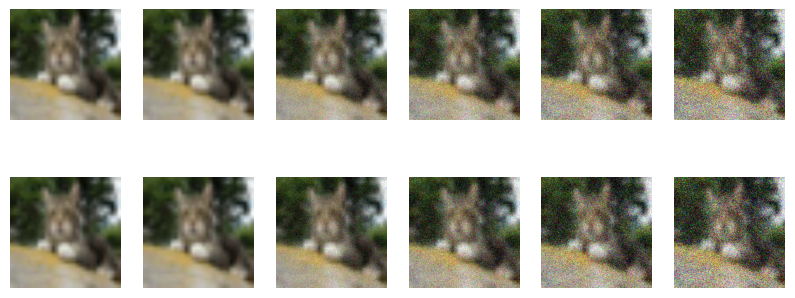

In [42]:
def fn():
    x, x1, _ = forward_diffusion_demo(5)
    T = 6
    fig, ax = plt.subplots(2, 6, figsize=(10, 4))
    for t in range(T):
        img = x[t].numpy()
        img = np.transpose(img, (1,2,0))
        ax[0,t].imshow(img)
        ax[0,t].axis("off")
    for t in range(T):
        img = x1[t].numpy()
        img = np.transpose(img, (1,2,0))
        ax[1,t].imshow(img)
        ax[1,t].axis("off")
    plt.show()


fn()

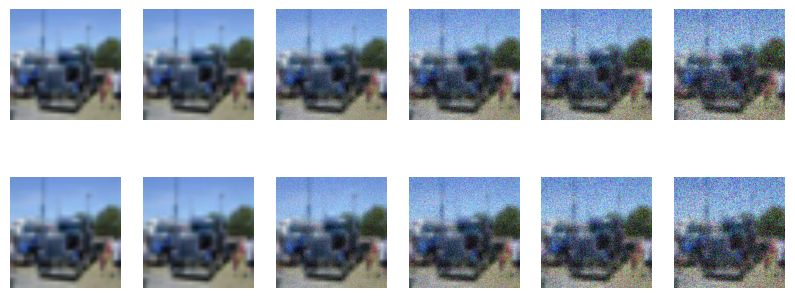

In [46]:
def fn():
    x, x1, _ = efficient_forward_diffusion_demo(5)
    T = 6
    fig, ax = plt.subplots(2, 6, figsize=(10, 4))
    for t in range(T):
        img = x[t].numpy()
        img = np.transpose(img, (1,2,0))
        ax[0,t].imshow(img)
        ax[0,t].axis("off")
    for t in range(T):
        img = x1[t].numpy()
        img = np.transpose(img, (1,2,0))
        ax[1,t].imshow(img)
        ax[1,t].axis("off")
    plt.show()


fn()

In [47]:
# use this code to free up gpu memory
gc.collect()
torch.cuda.empty_cache()
print("freed up some memory!")

freed up some memory!


## **Reverse (Denoising) Process**

Now, if we knew the conditional distribution $p(x_{t-1} | x_t)$, we could sample from it and get $x_{t-1}$ from $x_t$. In other words, we could reverse the forward diffusion process, ie, "denoise" the data step-by-step, starting from pure Gaussian noise $x_T$ and ending at the clean data sample $x_0$. This is the reverse diffusion process (also a Markov chain). However, we don't know the conditional distribution $p(x_{t-1} | x_t)$, so we need to learn it. Also, knowing the exact distribution is very difficult as that would involve knowing the distribution of very possible image.

Thus, we approximate $p(x_{t-1} | x_t)$ using a neural network, ie, the approximate version is denoted as $p_\theta(x_{t-1} | x_t)$, where $\theta$ are the parameters of the neural network. 

We assume that the reverse process is a Gaussian distribution, ie, $p_\theta(x_{t-1} | x_t) \sim \mathcal{N}(x_{t-1} | \mu_\theta(x_t), \Sigma_\theta(x_t))$, where $\mu_\theta(x_t)$ and $\Sigma_\theta(x_t)$ are the mean and covariance of the Gaussian distribution, respectively. The mean and covariance are learned (approximated/predicted) by the neural network.

However, as per the [original DDPM paper](https://arxiv.org/abs/2006.11239), the covariance is fixed, ie, $\Sigma_\theta(x_t) = \sigma^2 \cdot \mathbf{I}$, where $\sigma^2$ is a constant. The mean is $\mu_\theta$ is learned by the neural network. But, the [improved DDPM paper](https://arxiv.org/abs/2006.11239) suggested that the covariance should be learned as well, and that resulted in better performance. Since this notebook is about the basic (original) diffusion model, we will keep the covariance fixed. But, the neural network won't even predict the mean, as we'll see below.

## **Objective Function**

The goal of the objective function is to help the neural network learn the mean of the reverse diffusion process. But wait, we just mentioned above that the neural network won't even predict the mean. That's right! We will **reparametrize** the mean, such that the neural network will predict the **added noise** for the step $t$, ie, $\varepsilon_\theta(x_t, t)$.

The evidence lower bound ([ELBO](https://xyang35.github.io/2017/04/14/variational-lower-bound/)), also called variational lower bound, is used as the objective (or loss) function for the diffusion model.

The final loss function $L_t$ for a time step $t$ given $\varepsilon \sim \mathcal{N}(\mathbf{0}, \mathbf{I})$ is given by:

$$L_t = \left\| \varepsilon - \varepsilon_\theta(x_t, t) \right\|^2 = \left\| \varepsilon - \varepsilon_\theta(\sqrt{\bar{\alpha}_t} \cdot x_0 + \sqrt{1 - \bar{\alpha}_t} \cdot \varepsilon, \;\; t) \right\|^2$$

, where: 
- $\left\| \cdot \right\|^2$ is the squared L2 norm (Euclidean distance).
- $\varepsilon_\theta(x_t, t)$ is the predicted noise at time step $t$ given the noisy image $x_t$. 

The above loss function is computed for each time step $t$ from 1 to $T$, and the final loss is the sum of all the losses:
$$L = \sum_{t=1}^T L_t$$

Finally, the neural network is optimized using a simple mean squared error (MSE) between the true and the predicted Gaussian noise.

Entire workflow summarized (quoting from [The Annotated Diffusion model](https://huggingface.co/blog/annotated-diffusion)):

- We take a random sample $x_0$ from the real unknown and possibly complex data distribution $q(x_0)$.
- We sample a noise level $t$ uniformly between 1 and $T$ (ie, a random time step).
- We sample some noise from a Gaussian distribution and corrupt the input by this noise at level $t$.
- The neural network is trained to predict this noise based on the corrupted image $x_t$ (ie, noise applied on $x_0$ based on known variance schedule $\beta_t$).

## **The Entire Diffusion Model Architecture**

## **Training**

<figure>
  <div style="text-align: center;">
  <img src="https://huggingface.co/blog/assets/78_annotated-diffusion/training.png" width="500" alt="training"/>
  </div>
  <figcaption>
  <p style="text-align:center;">
  <b>Training the diffusion model.</b>
  </p>
  <p style="text-align:center;">
  Source: <a href="https://huggingface.co/blog/annotated-diffusion">The Annotated Diffusion Model by Hugging Face</a> (original by <a href="https://arxiv.org/abs/2006.11239">Ho et al. 2020</a>)
  </p>
  </figcaption>

## **Sampling**

<figure>
  <div style="text-align: center;">
  <img src="https://huggingface.co/blog/assets/78_annotated-diffusion/sampling.png" width="500" alt="training"/>
  </div>
  <figcaption>
  <p style="text-align:center;">
  <b>Sampling from the diffusion model.</b>
  </p>
  <p style="text-align:center;">
  Source: <a href="https://huggingface.co/blog/annotated-diffusion">The Annotated Diffusion Model by Hugging Face</a> (original by <a href="https://arxiv.org/abs/2006.11239">Ho et al. 2020</a>)
  </p>
  </figcaption>